In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib as mpl
import datetime
import os
from itertools import accumulate
from pandas.tseries.offsets import MonthEnd
import plotting 
from  matplotlib import colormaps as cmaps 
from scikit_posthocs import posthoc_dunn
import json
import statsmodels.api as sm
import statsmodels.formula.api as smf
import itertools
import matplotlib.patches as mpatches
from matplotlib import colors
from scipy.stats import entropy

In [4]:
from os import path
with open(path.expanduser("~") + "/sys_specific.json") as file: 
    params = json.load(file)
_HOME_ = params["home"] + "/PHD"
import modify_dataset

# Basics variables and parameters

In [5]:
phyto_abundances = pd.read_csv(_HOME_ + "/MSFD/Data/Modulo1/phyto_abund_modified.csv", index_col=0)
phyto_abundances.loc[:, "Date"] = pd.to_datetime(phyto_abundances["Date"])

In [6]:
with open(_HOME_ + "/ISPRA_20152017_Analysis/params.json") as file: 
    params = json.load(file)
best_path = params["best_path"]
best_path_sard = params["best_path_sard"]
ordered_regions = params["ordered_regions"]
seasons = params["seasons"]
sorted_season = params["sorted_season"]
sea_index = params["sea_index"]
ordered_id = params["ordered_id"]
sea_index_array = np.array(list(sea_index.values()))
del params

In [7]:
phyto_abund_simplified = modify_dataset.make_simplified_dataset(phyto_abundances, 0.7)
phyto_abund_simplified = modify_dataset.add_season_column(phyto_abund_simplified, seasons)
phyto_abund_simplified = modify_dataset.add_coast_dist_column(phyto_abund_simplified)
phyto_abund_simplified["Date"] = pd.to_datetime(phyto_abund_simplified["Date"]) + MonthEnd(0)
phyto_abund_simplified["Region"] = pd.Categorical(phyto_abund_simplified["Region"], categories = ordered_regions, ordered = True)

In [8]:
taxonomic_tree = pd.read_excel(_HOME_ + "/ISPRA_20152017_Analysis/Phyto_taxonomic_tree.xlsx")
taxonomic_tree.drop_duplicates(inplace=True)
phyto_abund_simplified = phyto_abund_simplified.merge(taxonomic_tree.loc[:,["ScientificName", "Genus", "Class"]], how = "left", left_on="Taxon", right_on="ScientificName")
phyto_abund_simplified["Class"] = phyto_abund_simplified["Class"].astype(str)

In [9]:
phyto_abund_simplified = modify_dataset.add_det_level_column(phyto_abund_simplified)

In [10]:
phyto_abund_simplified = phyto_abund_simplified.loc[:,
                                                    ["Region", "id", "Longitude", "Latitude", "Closest_coast", "Coast_dist", "Date", "Season_year", "Season", "Sample_depth", "Class", "Genus", "Det_level", "Taxon", "Num_cell_l", "file_name"]
                                                    ]

In [11]:
transects_info = pd.read_csv(_HOME_ + "/ISPRA_20152017_Analysis/transects_info.csv")
transects_info["Transect"] = transects_info["Transect"].str.upper()
phyto_abund_simplified = phyto_abund_simplified.merge(transects_info, how = "left", on = "id")

In [12]:
def Pielou_evenness(data): 
    if data.size == 1: 
        return 0
    H = entropy(data, base = 10)
    H_max = np.log10(len(data))
    return H / H_max

In [13]:
def Simpson_diversity(data): 
    if data.size == 1: 
        return 1
    return -np.log(1 / np.square(np.sum(data)) * np.sum(np.square(data)))

In [14]:
def Renyi_entropy(data, alpha): 
    if data.size == 1: 
        return 1
    if alpha == 0: 
        return np.log(np.unique(data).size)
    if alpha == 1: 
        return entropy(data)
    if alpha == 2: 
        return Simpson_diversity(data)
    if alpha == "inf": 
        return -np.log(np.max(data / np.sum(data)))

## taxa selection

In [12]:
relevant_samples = phyto_abund_simplified.query("Taxon != 'Other phytoplankton'").groupby(["id", "Date"], observed=True).agg({"Taxon" : "count", "Num_cell_l" : "sum"}).query("Taxon > 5 or Num_cell_l > 1000").index

In [14]:
phyto_abund_simplified.query("Taxon != 'Other phytoplankton'").query("Class == 'nan'").groupby("Taxon").agg(
    count = ("Taxon", "count"),
    abund = ("Num_cell_l", "sum")
)

count         abund
Taxon                               
Bacillariophyta     56  1.089579e+05
Chlorophyta        156  1.928183e+06
Flagellates         82  2.156914e+06
Haptophyta           1  1.507964e+02
Noctilucea           9  8.000000e+02
Non flagellates     10  4.373097e+03

In [13]:
higher_than_class = ['Other phytoplankton', "Haptophyta", "Noctilucea", "Non flagellates"]

In [14]:
relevant_taxa = phyto_abund_simplified.query("Taxon not in @higher_than_class").groupby("Taxon").agg(
    count = ("id", "count"),
    abund = ("Num_cell_l", "sum")
).query("count >= 10 or abund >= 1000").index

In [17]:
### create site_taxa matrix
phyto_abund_simplified.set_index(["id", "Date"]).loc[relevant_samples].query("Taxon in @relevant_taxa").reset_index().pivot_table(index = ["Region", "id", "Date"], columns="Taxon", values = "Num_cell_l", fill_value=0).reset_index().to_csv(_HOME_ + "/PHD/ISPRA_20152017_Analysis/site_taxa_matrix.csv", index = False)

# Overall Richness level

In [13]:
# Create the directory if it doesn't exist
directory = _HOME_ + "/ISPRA_20152017_Analysis/Plots/Rich_levels"
if not os.path.exists(directory):
    os.makedirs(directory)

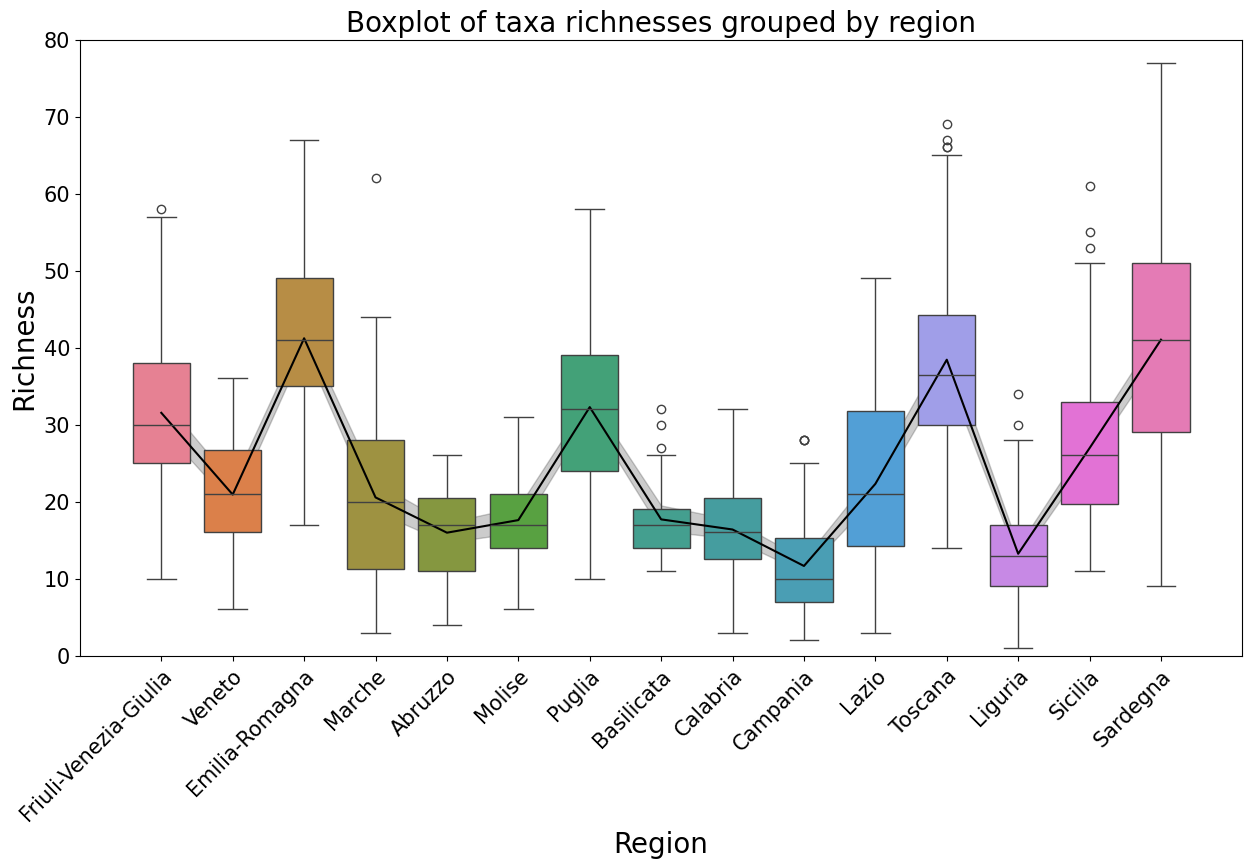

In [13]:
fig, ax = plt.subplots(1,1, figsize=(15, 8))
sns.boxplot(
    phyto_abund_simplified.query("Taxon != 'Other phytoplankton'").groupby(["Region", "id", "Date"], observed = True).count().loc[ordered_regions,:].reset_index(),
    x = "Region", 
    y = "Taxon",
    hue = "Region",
    ax = ax
)
sns.lineplot(
    phyto_abund_simplified.query("Taxon != 'Other phytoplankton'").groupby(["Region", "id", "Date"], observed = True).count().loc[ordered_regions,:].reset_index(),
    x = "Region", 
    y = "Taxon",
    color = "k",
    ax = ax

)
plt.title("Boxplot of taxa richnesses grouped by region", size = 20)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(labels = ax.get_xticklabels(), rotation = 45, rotation_mode = "anchor", ha = "right", fontsize = 15);
ax.set_xlabel(xlabel = "Region", fontsize = 20)
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(labels = ax.get_yticklabels(), fontsize = 15);
ax.set_ylabel("Richness", fontsize = 20)
ax.set_ylim(0, 80)
plt.savefig(_HOME_ + "/ISPRA_20152017_Analysis/Plots/Rich_levels/boxplot_richness_by_region.png",bbox_inches='tight')

/home/alberto/miniconda3/lib/python3.11/site-packages/scikit_posthocs/_posthocs.py:357: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  x_lens = x.groupby(_group_col)[_val_col].count()
/home/alberto/miniconda3/lib/python3.11/site-packages/scikit_posthocs/_posthocs.py:360: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  x_ranks_avg = x.groupby(_group_col)['ranks'].mean()


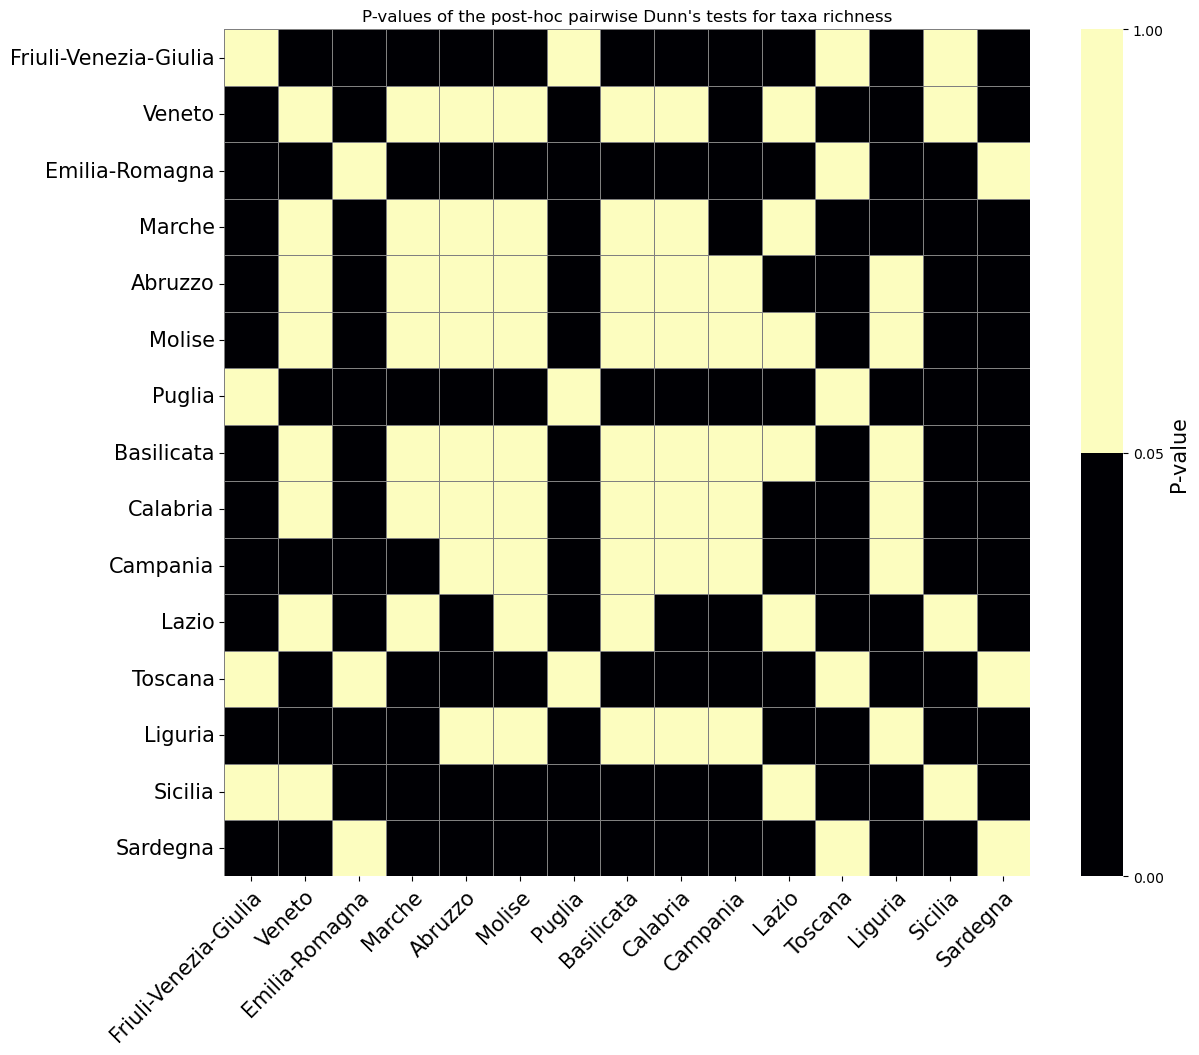

In [30]:
fig, ax = plt.subplots(1,1, figsize=(13, 11))
bounds = [0, 0.05, 1]
cm = cmaps.get_cmap("magma").resampled(len(bounds)-1)
norm = mpl.colors.BoundaryNorm(bounds, len(bounds))
richness_data = phyto_abund_simplified.query("Taxon != 'Other phytoplankton'").groupby(["Region", "id", "Date"], observed=True).count().loc[ordered_regions, "Taxon"].reset_index()
p_values_richness = posthoc_dunn(richness_data, group_col="Region", val_col="Taxon", p_adjust="bonferroni")
p_values_richness = p_values_richness.loc[ordered_regions]

sns.heatmap(p_values_richness, ax=ax, cmap=cm, norm=norm, linewidth=0.5, linecolor="grey")
cbar = ax.collections[0].colorbar
cbar.set_label("P-value", size=15)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, rotation_mode = "anchor", ha = "right", fontsize = 15)
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(ax.get_yticklabels(), fontsize = 15)
plt.title("P-values of the post-hoc pairwise Dunn's tests for taxa richness")
plt.savefig(_HOME_ + "/PHD/ISPRA_20152017_Analysis/Plots/Rich_levels/P_val_Dunn__region.png")

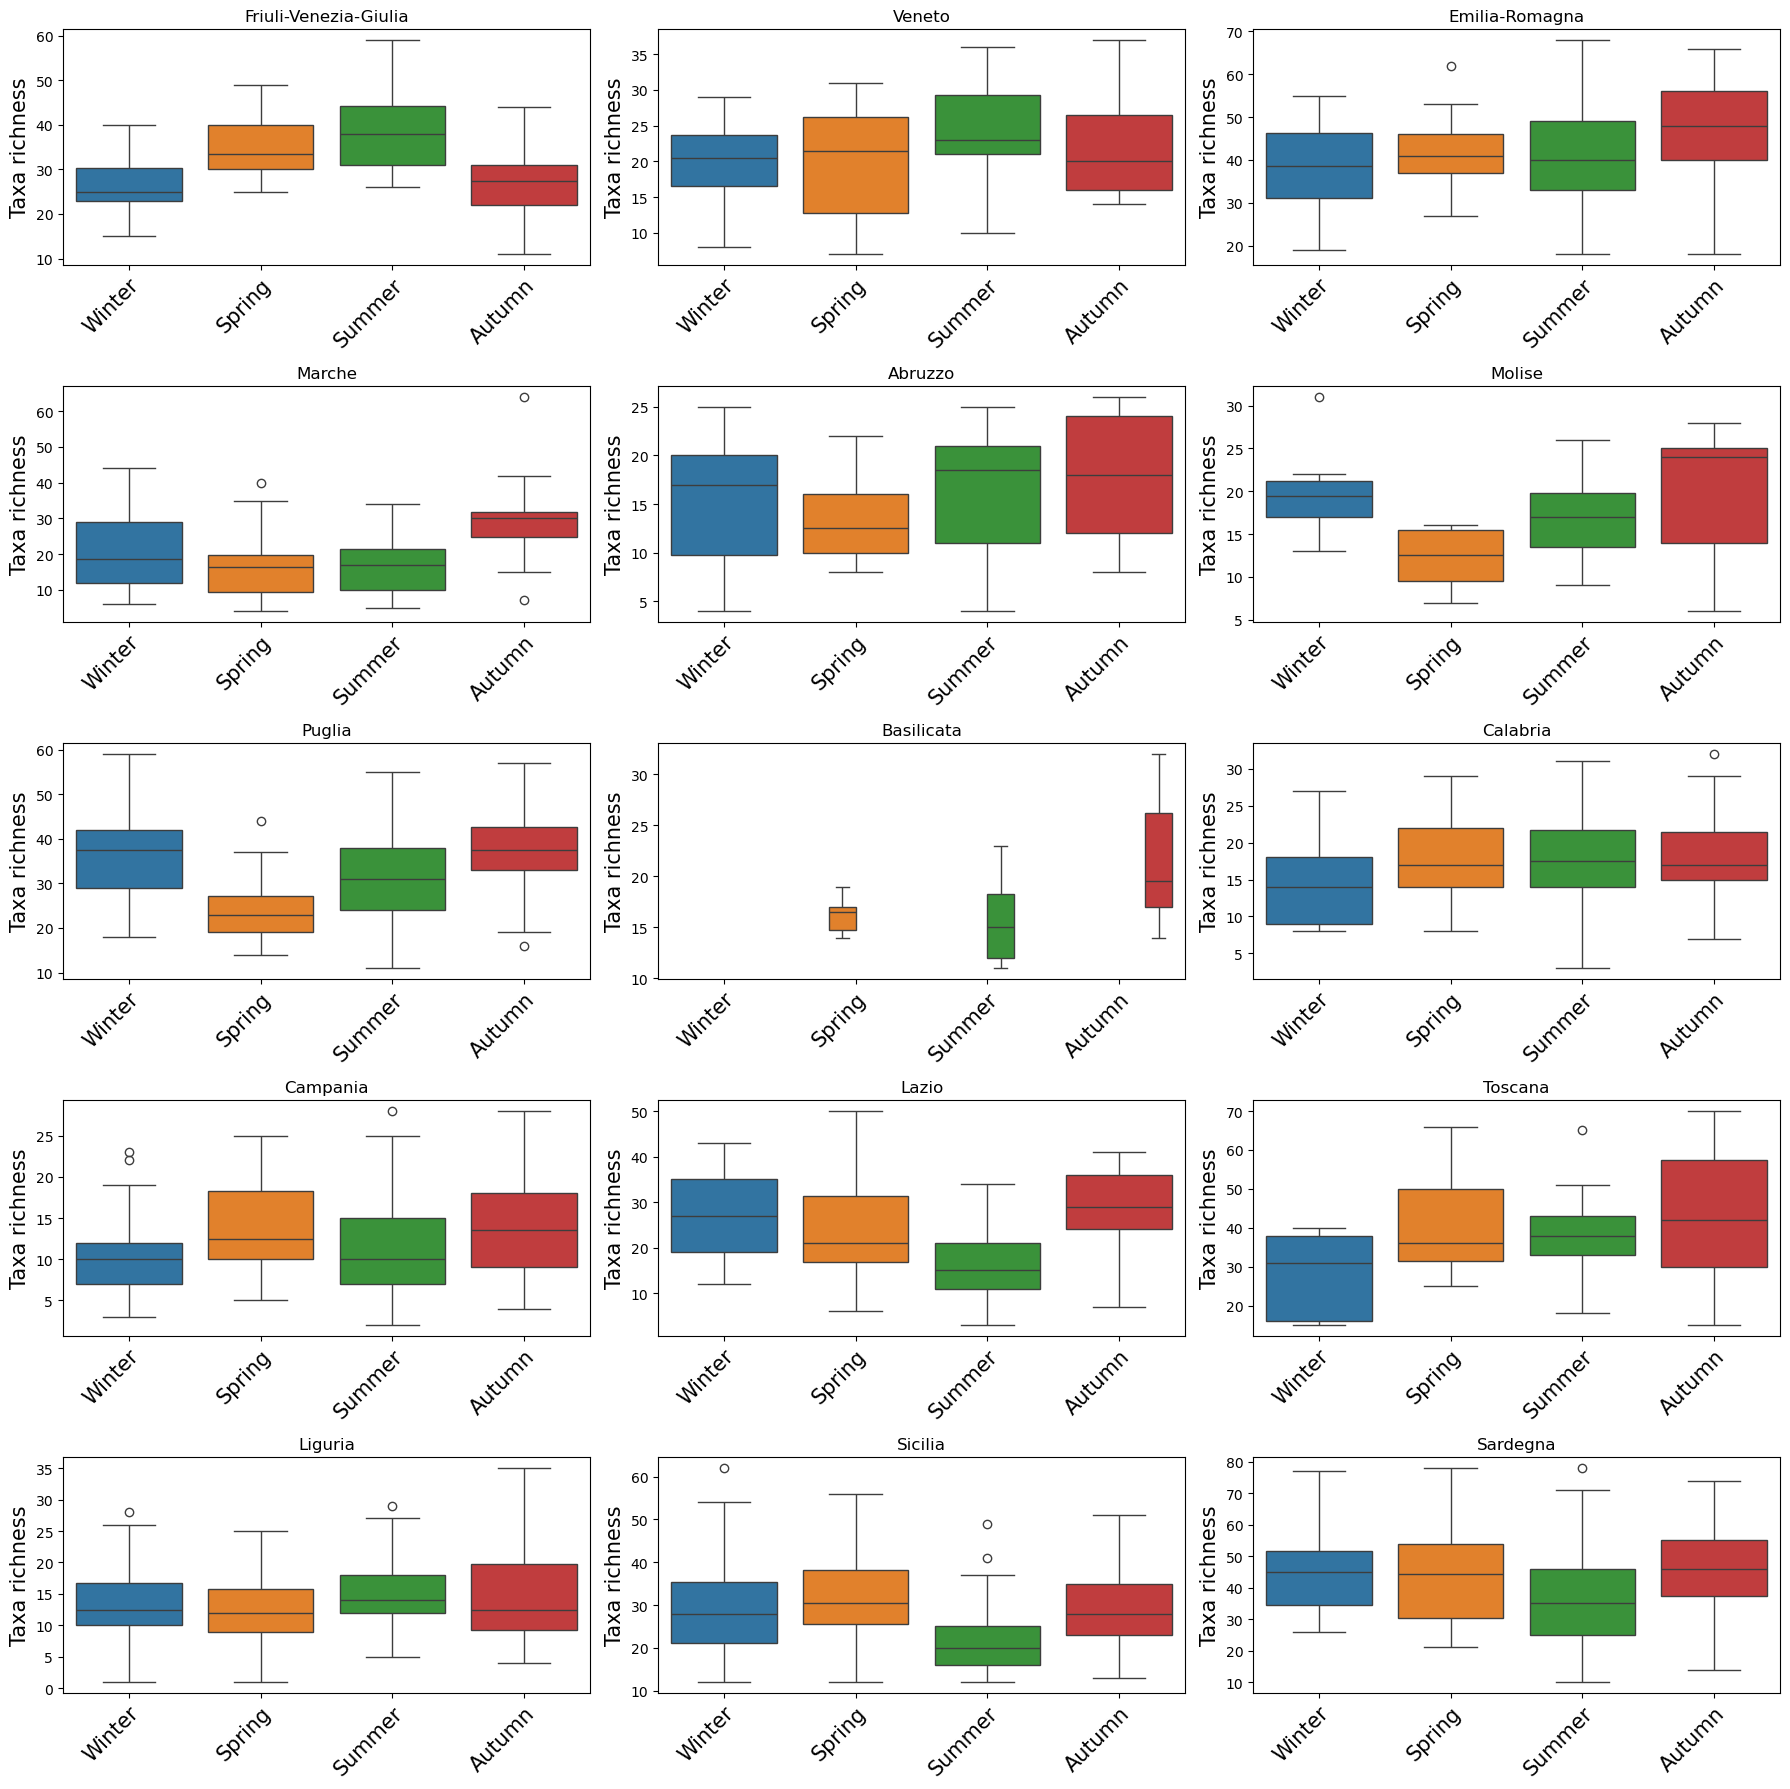

In [31]:
fig, axs = plt.subplots(5, 3, figsize=(18, 18))
axs = axs.flatten()

for ax, (region, df_region) in zip(axs, phyto_abund_simplified.groupby("Region", observed=True)):
    sns.boxplot(
        df_region.groupby(["id", "Date"], observed = True).agg({"Taxon" : "count", "Season" : "first"}).reset_index(),
        x = "Season",
        y = "Taxon",
        hue = "Season",
        ax = ax
    )
    n_samples = df_region.groupby("Season", observed = True).agg({"id" : "nunique"}).reset_index()
    ax.set_title(region)
    ax.set_xlabel("")
    ax.set_ylabel("Taxa richness", size = 15)
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, rotation_mode = "anchor", ha = "right", fontsize = 15);
plt.tight_layout()
plt.savefig(_HOME_ + "/PHD/ISPRA_20152017_Analysis/Plots/Rich_levels/boxplot_by_season_per_region.png")

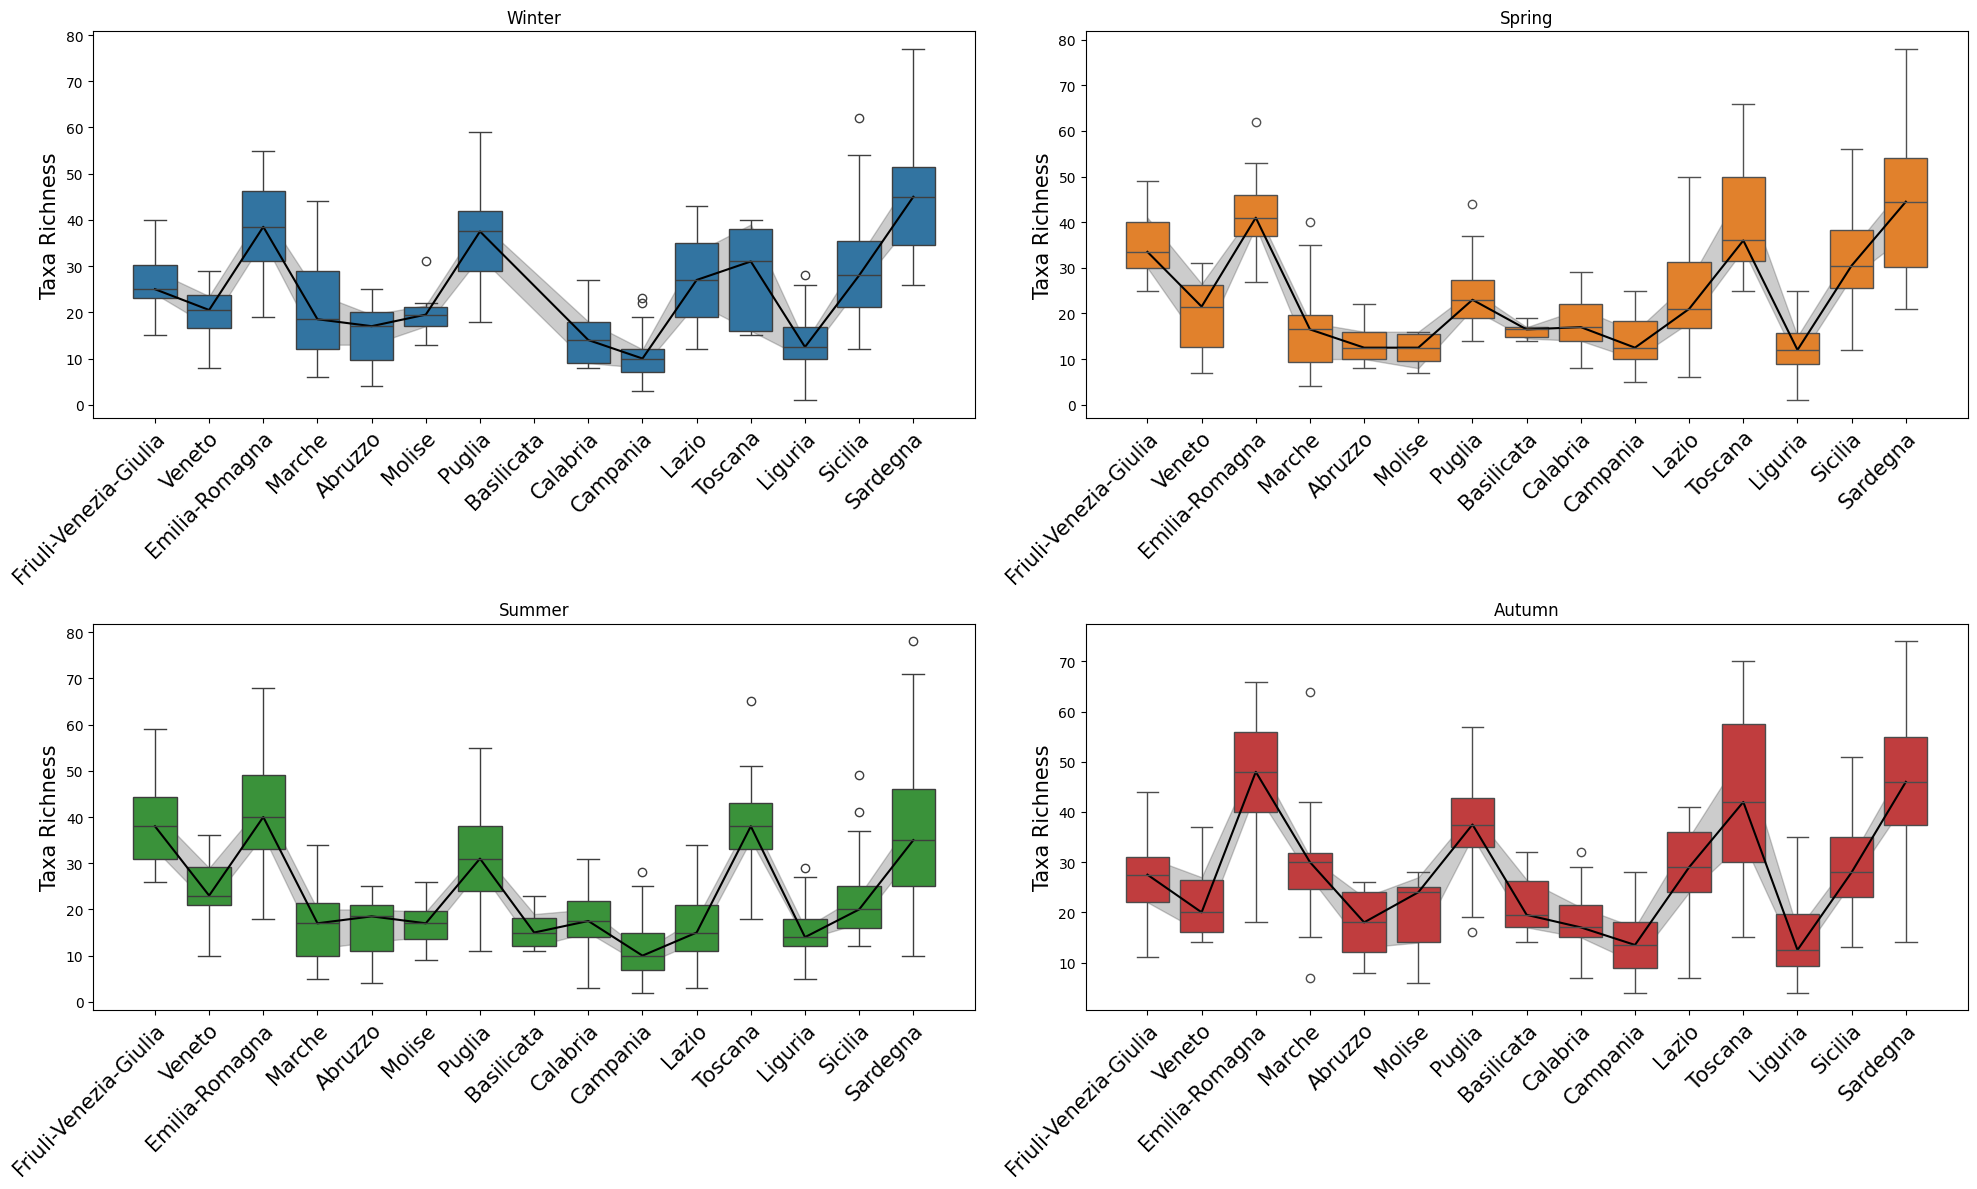

In [28]:
fig, axs = plt.subplots(2, 2, figsize=(20, 12))
axs = axs.flatten()

palette = sns.color_palette("tab10", n_colors = 4)
colors = dict(zip(seasons, palette))
for ax, (season, df_season) in zip(axs, phyto_abund_simplified.groupby("Season", observed=True)):
    sns.boxplot(
        df_season.groupby(["id", "Date"], observed = True).agg({"Taxon" : "count", "Region" : "first"}).reset_index(),
        x = "Region",
        y = "Taxon",
        color = colors[season],
        ax = ax
    )
    sns.lineplot(
        df_season.groupby(["id", "Date"], observed = True).agg({"Taxon" : "count", "Region" : "first"}).reset_index(),
        x = "Region",
        y = "Taxon",
        color = "black",
        estimator= "median",
        ax = ax
    )
    #n_samples = df_season.groupby("Season", observed = True).agg({"id" : "nunique"}).reset_index()
    ax.set_title(season)
    ax.set_xlabel("")
    ax.set_ylabel("Taxa Richness", size = 15)
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, rotation_mode = "anchor", ha = "right", fontsize = 15);
plt.tight_layout()
#plt.savefig(_HOME_ + "/ISPRA_20152017_Analysis/Plots/Abund_levels/boxplot_by_season.png", bbox_inches='tight')

# Overall evenness levels

In [15]:
# Create the directory if it doesn't exist
directory = _HOME_ + "/ISPRA_20152017_Analysis/Plots/Even_levels"
if not os.path.exists(directory):
    os.makedirs(directory)

(-0.05, 1.05)

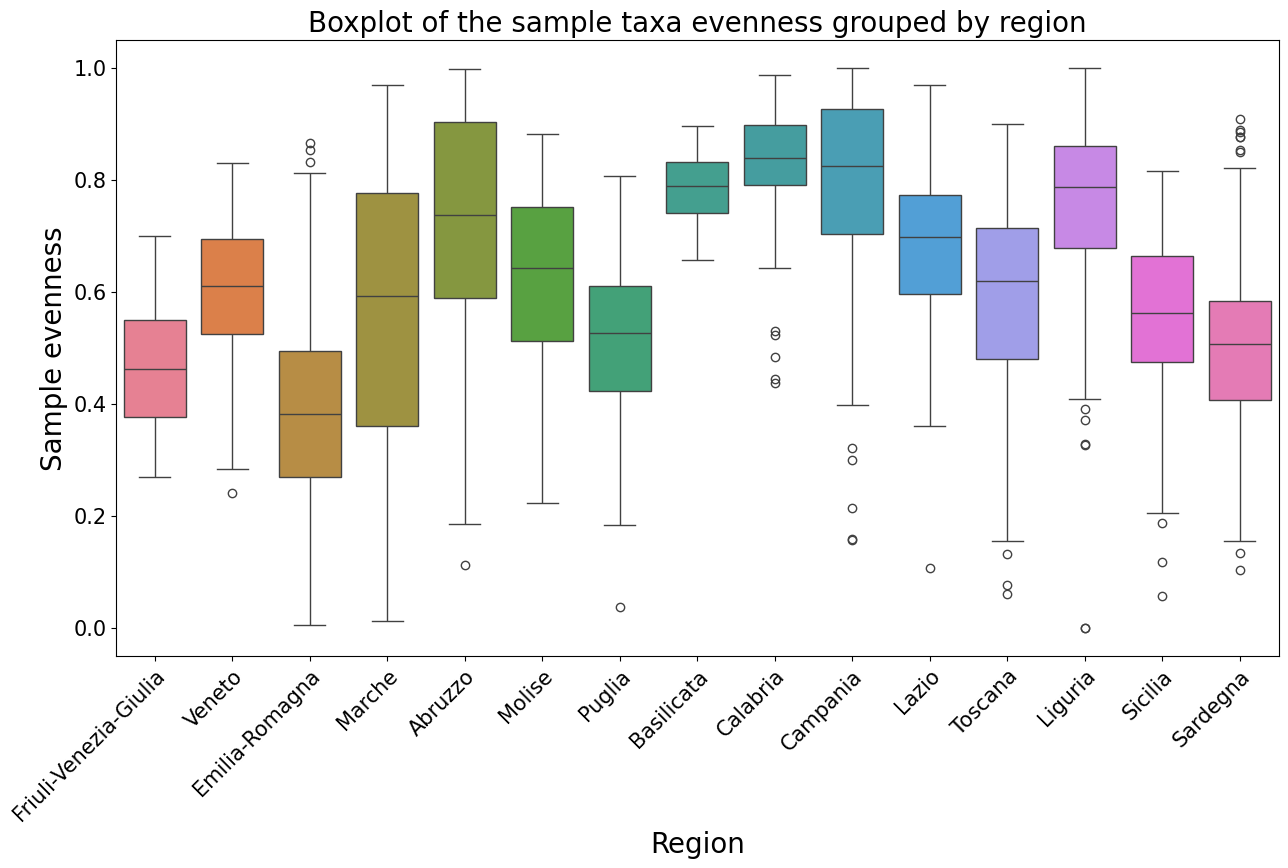

In [16]:
fig, ax = plt.subplots(1,1, figsize=(15, 8))
sns.boxplot(
    phyto_abund_simplified.query("Taxon != 'Other phytoplankton'")[["Region", "id", "Date", "Num_cell_l"]].groupby(["Region", "id", "Date"], observed = True).agg(Pielou_evenness).loc[ordered_regions,:].reset_index(),
    x = "Region", 
    y = "Num_cell_l",
    hue = "Region",
    ax = ax
)
plt.title("Boxplot of sample taxa evenness grouped by region", size = 20)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(labels = ax.get_xticklabels(), rotation = 45, rotation_mode = "anchor", ha = "right", fontsize = 15);
ax.set_xlabel(xlabel = "Region", fontsize = 20)
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(labels = ax.get_yticklabels(), fontsize = 15);
ax.set_ylabel("Sample evenness", fontsize = 20)
ax.set_ylim(-0.05, 1.05)
#plt.savefig(_HOME_ + "/PHD/ISPRA_20152017_Analysis/Plots/Even_levels/boxplot_evenness_by_region.png",bbox_inches='tight')

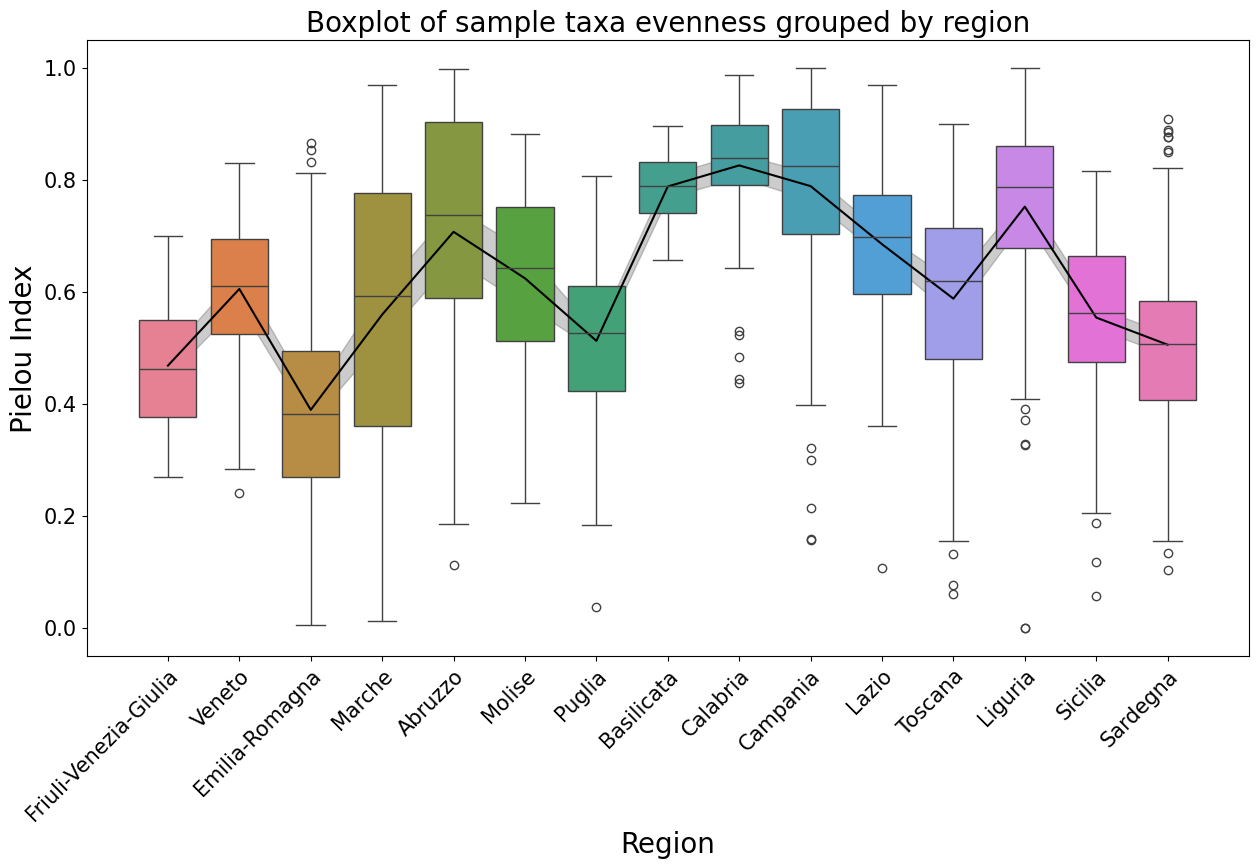

In [26]:
fig, ax = plt.subplots(1,1, figsize=(15, 8))
sns.boxplot(
    phyto_abund_simplified.query("Taxon != 'Other phytoplankton'")[["Region", "id", "Date", "Num_cell_l"]].groupby(["Region", "id", "Date"], observed = True).agg(Pielou_evenness).loc[ordered_regions,:].reset_index(),
    x = "Region", 
    y = "Num_cell_l",
    hue = "Region",
    ax = ax
)
sns.lineplot(
    phyto_abund_simplified.query("Taxon != 'Other phytoplankton'")[["Region", "id", "Date", "Num_cell_l"]].groupby(["Region", "id", "Date"], observed = True).agg(Pielou_evenness).loc[ordered_regions,:].reset_index(),
    x = "Region", 
    y = "Num_cell_l",
    color = "k",
    ax = ax

)
plt.title("Boxplot of sample taxa evenness grouped by region", size = 20)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(labels = ax.get_xticklabels(), rotation = 45, rotation_mode = "anchor", ha = "right", fontsize = 15);
ax.set_xlabel(xlabel = "Region", fontsize = 20)
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(labels = ax.get_yticklabels(), fontsize = 15);
ax.set_ylabel("Pielou Index", fontsize = 20)
ax.set_ylim(-0.05, 1.05)
plt.savefig(_HOME_ + "/ISPRA_20152017_Analysis/Plots/Even_levels/boxplot_Pielou_evenness_by_region.png",bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(13, 11))
bounds = [0, 0.05, 1]
cm = cmaps.get_cmap("magma").resampled(len(bounds)-1)
norm = mpl.colors.BoundaryNorm(bounds, len(bounds))
evenness_data = phyto_abund_simplified.query("Taxon != 'Other phytoplankton'")[["Region", "id", "Date", "Num_cell_l"]].groupby(["Region", "id", "Date"], observed = True).agg(Pielou_evenness).loc[ordered_regions,:].reset_index()
p_values = posthoc_dunn(evenness_data, group_col="Region", val_col="Num_cell_l", p_adjust="bonferroni")
p_values = p_values.loc[ordered_regions]

sns.heatmap(p_values_richness, ax=ax, cmap=cm, norm=norm, linewidth=0.5, linecolor="grey")
cbar = ax.collections[0].colorbar
cbar.set_label("P-value", size=15)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, rotation_mode = "anchor", ha = "right", fontsize = 15)
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(ax.get_yticklabels(), fontsize = 15)
plt.title("P-values of the post-hoc pairwise Dunn's tests for taxa evenness")
plt.savefig(_HOME_ + "/PHD/ISPRA_20152017_Analysis/Plots/Even_levels/P_val_Dunn__region.png")

In [ ]:
fig, axs = plt.subplots(5, 3, figsize=(18, 18))
axs = axs.flatten()

for ax, (region, df_region) in zip(axs, phyto_abund_simplified.query("Taxon != 'Other phytoplankton'")[["Region", "id", "Date", "Season", "Num_cell_l"]].groupby("Region", observed=True)):
    sns.boxplot(
        df_region.groupby(["id", "Date"], observed = True).agg({"Num_cell_l" : Pielou_evenness, "Season" : "first"}).reset_index(),
        x = "Season",
        y = "Num_cell_l",
        hue = "Season",
        ax = ax
    )
    n_samples = df_region.groupby("Season", observed = True).agg({"id" : "nunique"}).reset_index()
    ax.set_title(region)
    ax.set_xlabel("")
    ax.set_ylabel("Taxa evenness", size = 15)
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, rotation_mode = "anchor", ha = "right", fontsize = 15);
plt.tight_layout()
plt.savefig(_HOME_ + "/PHD/ISPRA_20152017_Analysis/Plots/Even_levels/boxplot_by_season_per_region.png")

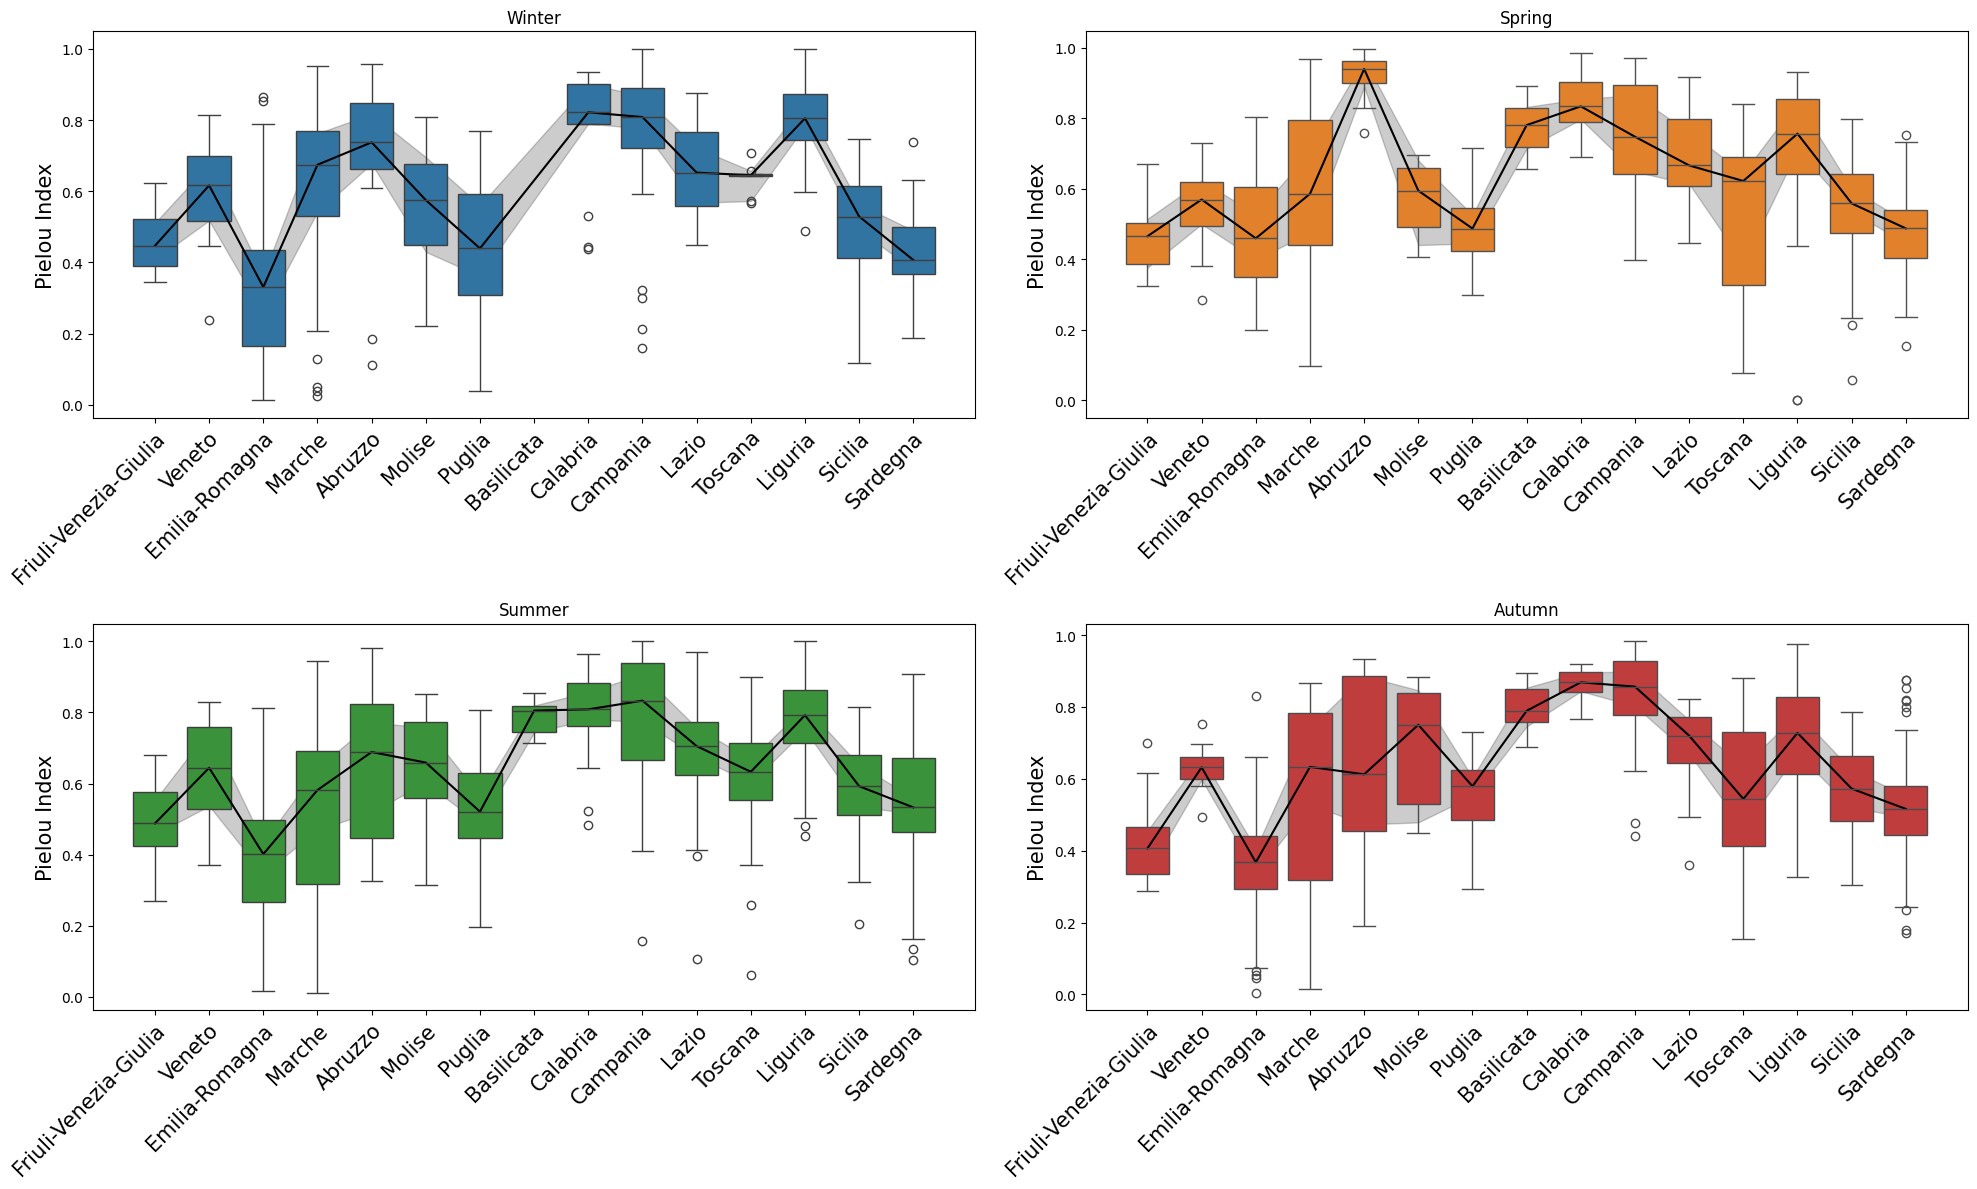

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(20, 12))
axs = axs.flatten()

palette = sns.color_palette("tab10", n_colors = 4)
colors = dict(zip(seasons, palette))
for ax, (season, df_season) in zip(axs, phyto_abund_simplified.query("Taxon != 'Other phytoplankton'").groupby("Season", observed=True)):
    sns.boxplot(
        df_season.groupby(["id", "Date"], observed = True).agg({"Num_cell_l" : Pielou_evenness, "Region" : "first"}).reset_index(),
        x = "Region",
        y = "Num_cell_l",
        color = colors[season],
        ax = ax
    )
    sns.lineplot(
        df_season.groupby(["id", "Date"], observed = True).agg({"Num_cell_l" : Pielou_evenness, "Region" : "first"}).reset_index(),
        x = "Region",
        y = "Num_cell_l",
        color = "black",
        estimator="median",
        ax = ax
    )
    ax.set_title(season)
    ax.set_xlabel("")
    ax.set_ylabel("Pielou Index", size = 15)
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, rotation_mode = "anchor", ha = "right", fontsize = 15);
plt.tight_layout()
#plt.savefig(_HOME_ + "/ISPRA_20152017_Analysis/Plots/Abund_levels/boxplot_by_season.png", bbox_inches='tight')

<Axes: xlabel='Taxon', ylabel='Num_cell_l'>

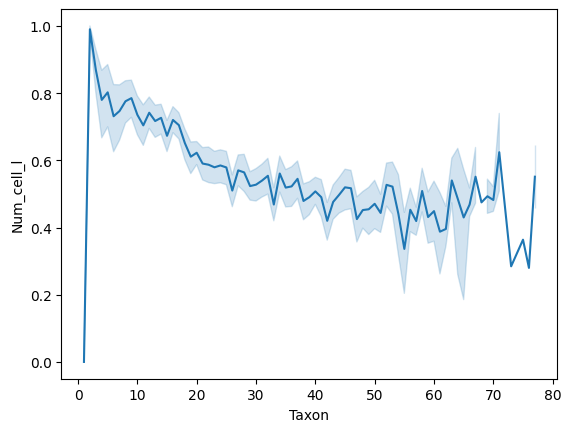

In [18]:
sns.lineplot(phyto_abund_simplified.query("Taxon != 'Other phytoplankton'").groupby(["id", "Date"]).agg({"Num_cell_l" : Pielou_evenness, "Taxon" : "count"}), 
                x = "Taxon", y = "Num_cell_l")

<Axes: xlabel='Taxon', ylabel='Num_cell_l'>

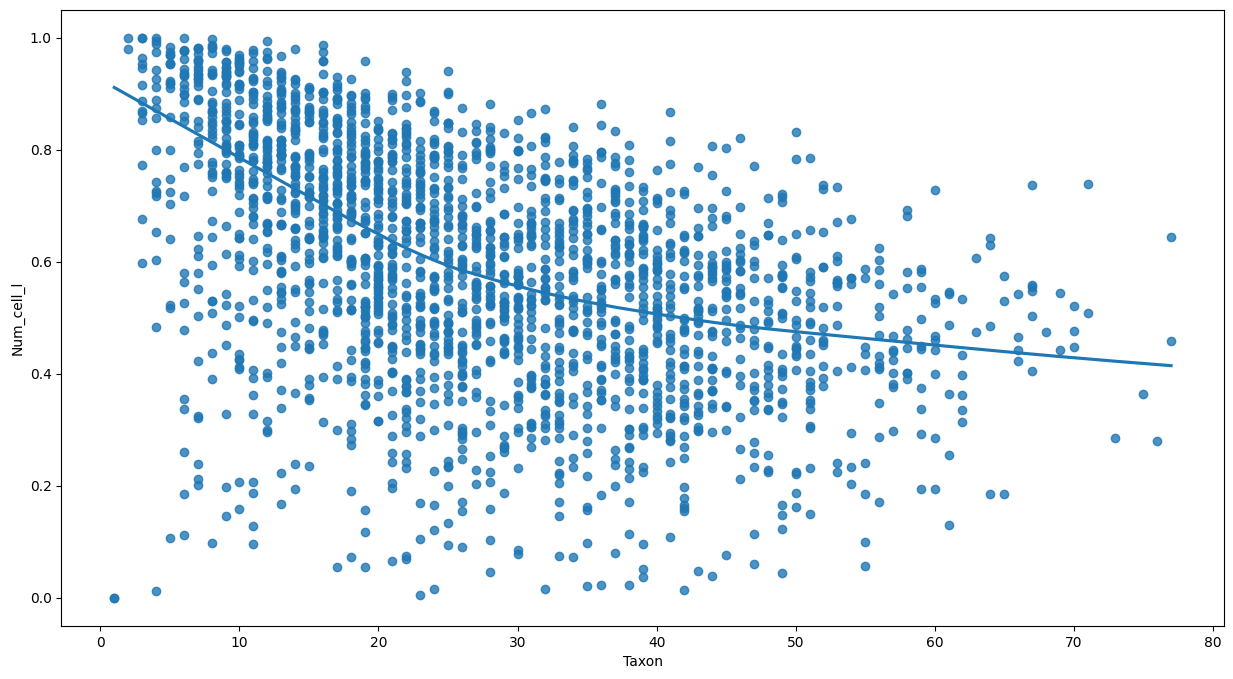

In [19]:
fig, ax = plt.subplots(1,1, figsize=(15, 8))
sns.regplot(
    phyto_abund_simplified.query("Taxon != 'Other phytoplankton'").groupby(["id", "Date"]).agg({"Num_cell_l" : Pielou_evenness, "Taxon" : "count"}), 
                x = "Taxon", y = "Num_cell_l", 
                ax = ax, 
                lowess = True
)

In [1]:
from scipy import stats

In [21]:
stats.spearmanr(*phyto_abund_simplified.query("Taxon != 'Other phytoplankton'").groupby(["id", "Date"]).agg({"Num_cell_l" : Pielou_evenness, "Taxon" : "count"}).to_numpy().T)

SignificanceResult(statistic=-0.4991584905205467, pvalue=3.758285830713794e-140)

In [20]:
stats.spearmanr(*phyto_abund_simplified.query("Taxon != 'Other phytoplankton'").groupby(["id", "Date"]).agg({"Num_cell_l" : "sum", "Taxon" : "count"}).to_numpy().T)

SignificanceResult(statistic=0.5625975643748059, pvalue=1.8825813383777217e-185)

In [19]:
stats.spearmanr(*phyto_abund_simplified.query("Taxon != 'Other phytoplankton'").groupby(["id", "Date"]).agg({"Num_cell_l" : ["sum",Pielou_evenness]}).to_numpy().T)

SignificanceResult(statistic=-0.6381865075034592, pvalue=4.225696647130707e-254)

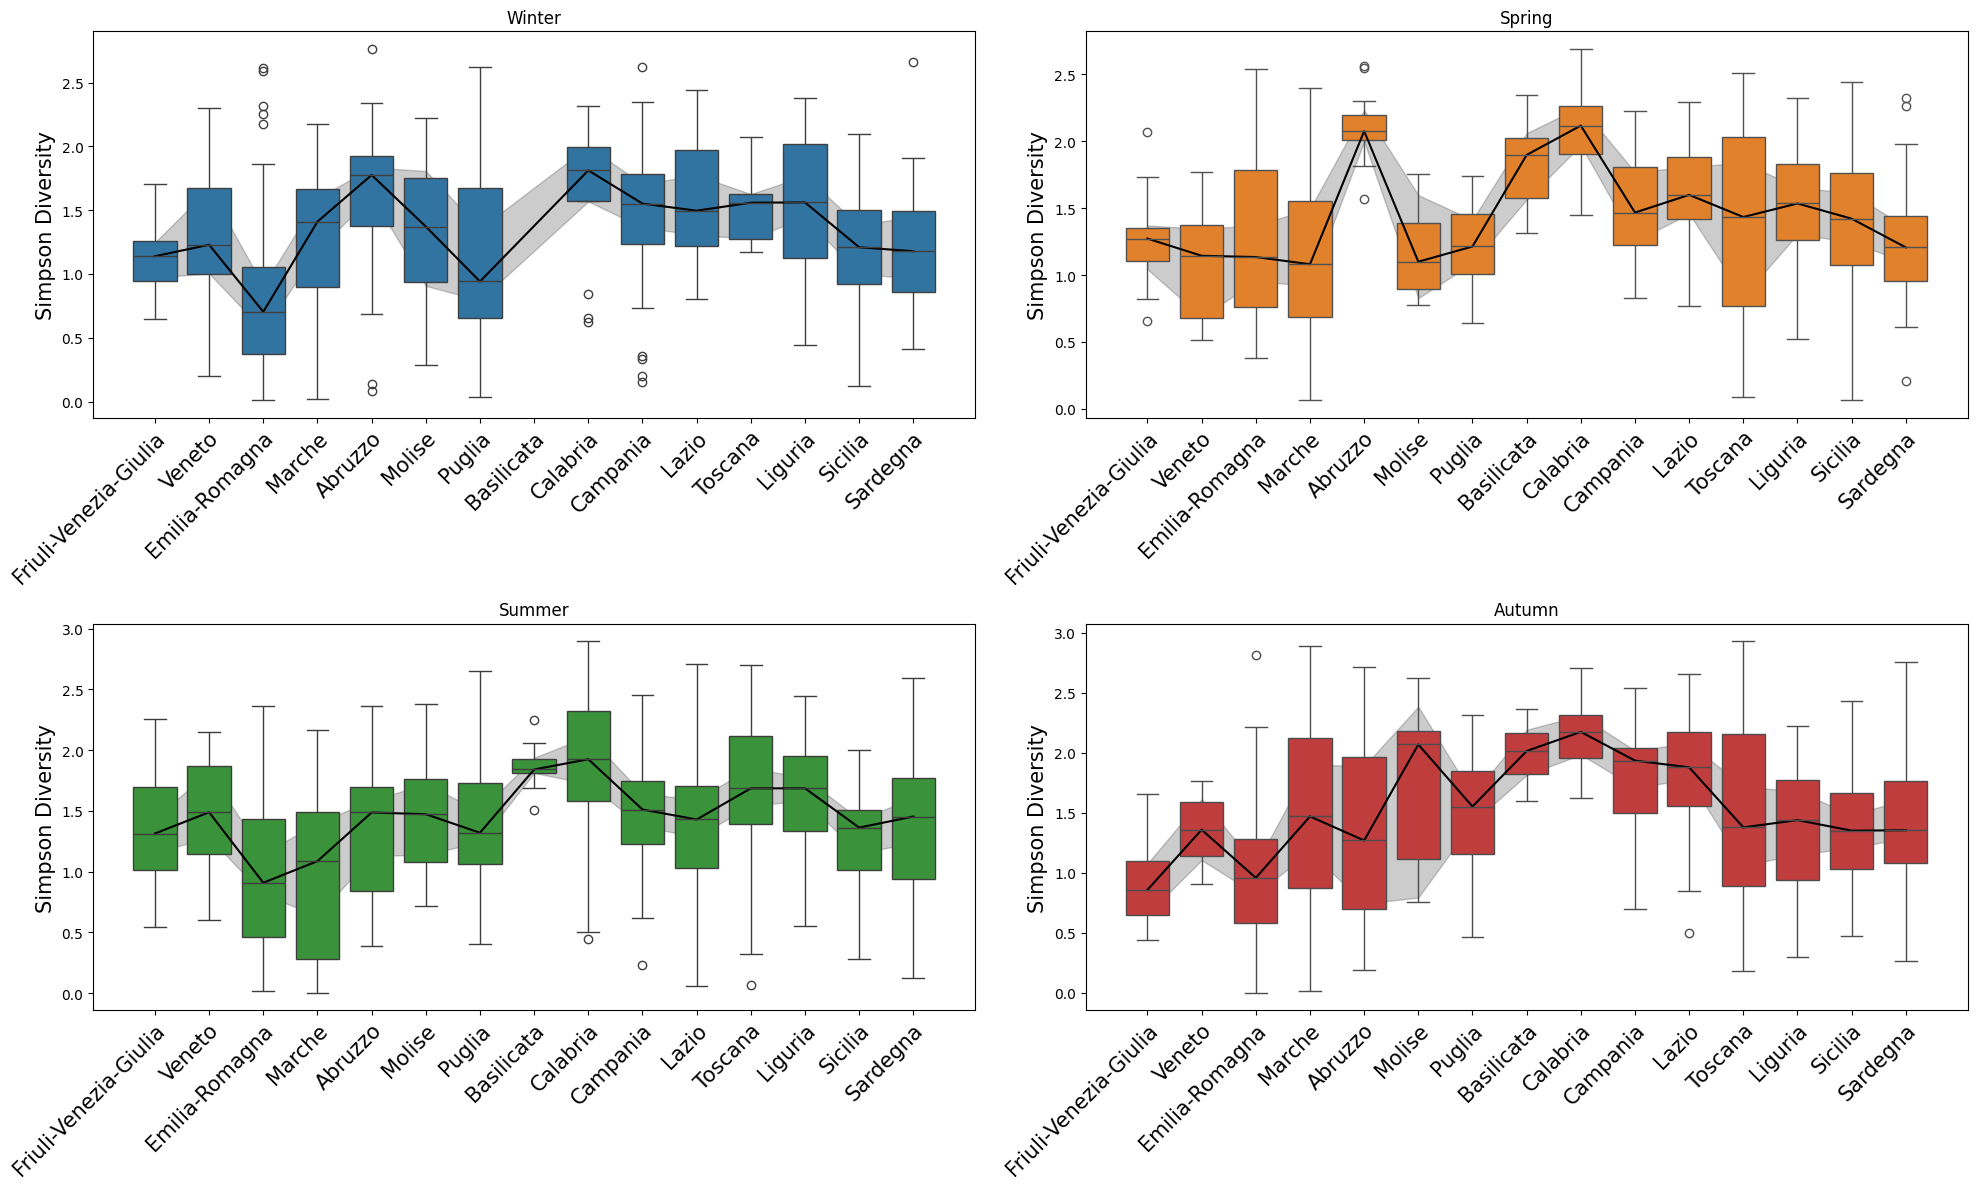

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(20, 12))
axs = axs.flatten()

palette = sns.color_palette("tab10", n_colors = 4)
colors = dict(zip(seasons, palette))
for ax, (season, df_season) in zip(axs, phyto_abund_simplified.query("Taxon != 'Other phytoplankton'").groupby("Season", observed=True)):
    sns.boxplot(
        df_season.groupby(["id", "Date"], observed = True).agg({"Num_cell_l" : Simpson_diversity, "Region" : "first"}).reset_index(),
        x = "Region",
        y = "Num_cell_l",
        color = colors[season],
        ax = ax
    )
    sns.lineplot(
        df_season.groupby(["id", "Date"], observed = True).agg({"Num_cell_l" : Simpson_diversity, "Region" : "first"}).reset_index(),
        x = "Region",
        y = "Num_cell_l",
        color = "black",
        estimator="median",
        ax = ax
    )
    #n_samples = df_season.groupby("Season", observed = True).agg({"id" : "nunique"}).reset_index()
    ax.set_title(season)
    ax.set_xlabel("")
    ax.set_ylabel("Simpson Diversity", size = 15)
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, rotation_mode = "anchor", ha = "right", fontsize = 15);
plt.tight_layout()
#plt.savefig(_HOME_ + "/ISPRA_20152017_Analysis/Plots/Abund_levels/boxplot_by_season.png", bbox_inches='tight')

# corr. among species

In [96]:
species_spearman = phyto_abund_simplified.set_index(["id", "Date"]).loc[relevant_samples].query("Taxon in @relevant_taxa").pivot_table(index = ["id", "Date"], columns = "Taxon", values = "Num_cell_l", fill_value=0).corr("spearman")

In [97]:
np.fill_diagonal(species_spearman.values, np.nan)

<Axes: xlabel='Taxon', ylabel='Taxon'>

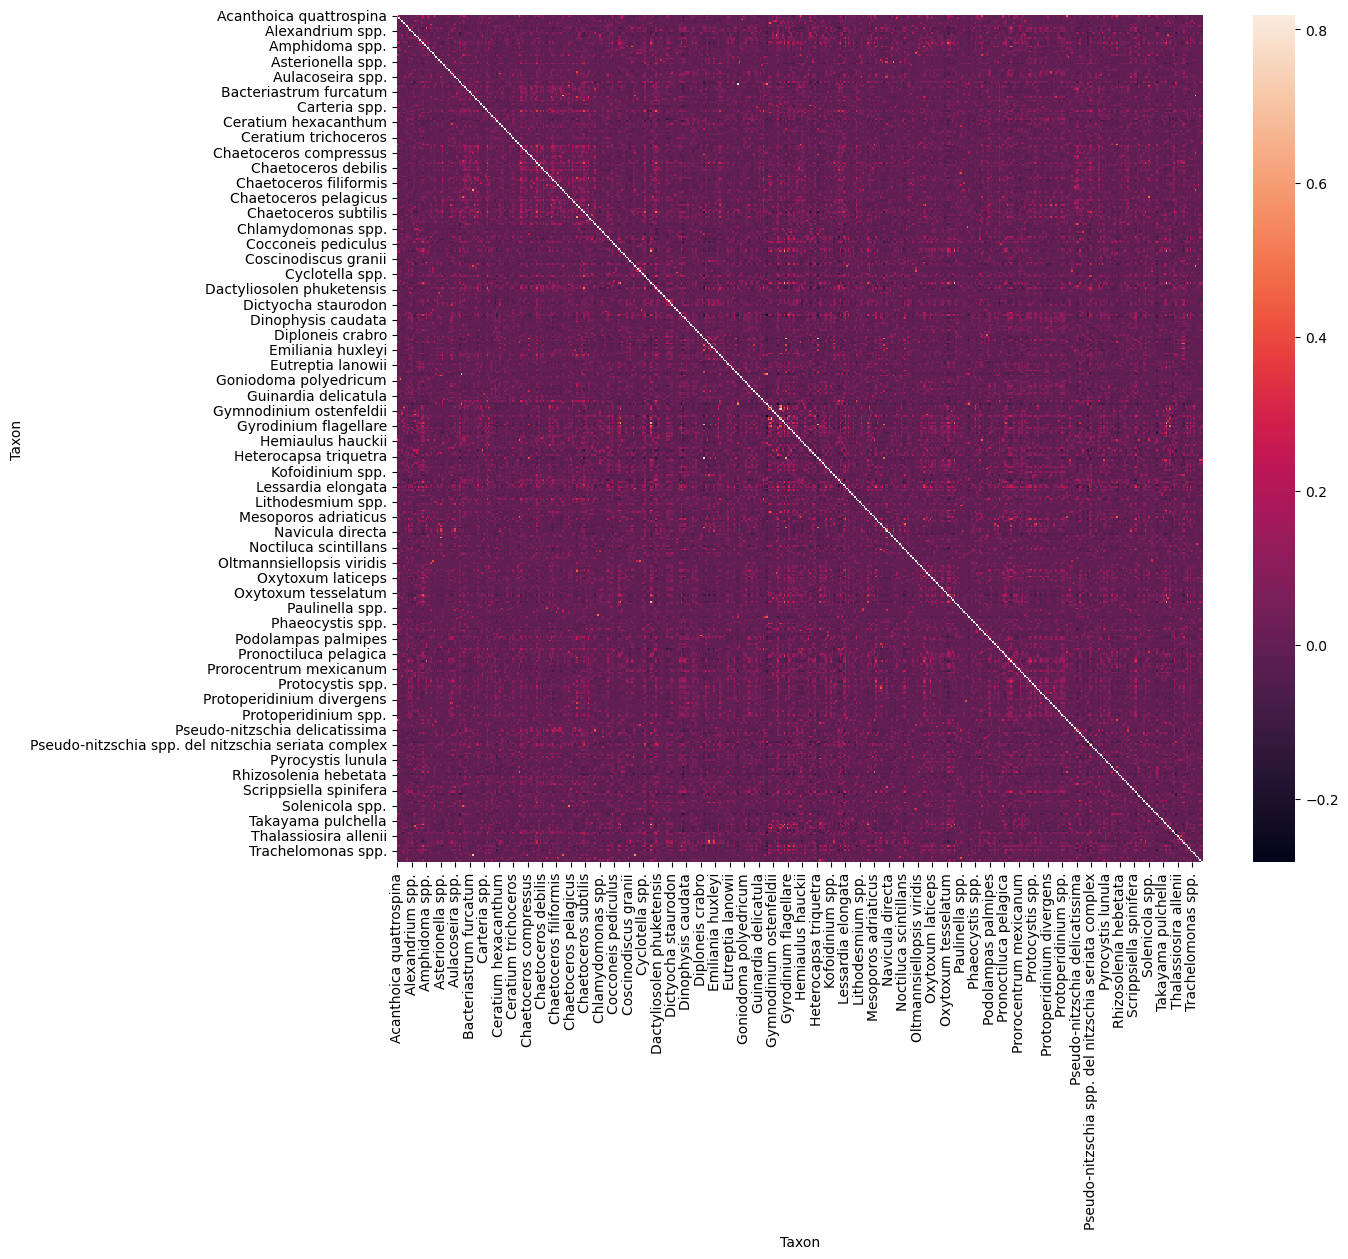

In [98]:
fig, ax = plt.subplots(1,1, figsize=(13, 11))
sns.heatmap(species_spearman, ax = ax)

In [26]:
phyto_abund_simplified.set_index(["id", "Date"]).loc[relevant_samples].pivot_table(index = ["id", "Date"], columns = "Taxon", values = "Num_cell_l", fill_value=0).loc[:, ["Eutreptiella marina", "Craspedotella pileolus"]]

Taxon                         Eutreptiella marina  Craspedotella pileolus
id                Date                                                   
0004-MS00200_TR03 2015-08-31                  0.0                     0.0
                  2015-10-31                  0.0                     0.0
                  2015-12-31                  0.0                     0.0
                  2016-01-31                  0.0                     0.0
                  2016-04-30                  0.0                     0.0
...                                           ...                     ...
VOL120            2017-02-28                  0.0                     0.0
                  2017-05-31                  0.0                     0.0
                  2017-07-31                  0.0                     0.0
                  2017-09-30                  0.0                     0.0
                  2017-11-30                  0.0                     0.0

[2183 rows x 2 columns]

In [24]:
species_spearman.unstack().sort_values(ascending=False).head(10)

Taxon                  Taxon                    
Eutreptiella marina    Craspedotella pileolus       1.0
Glenodinium spp.       Oxytoxum ovale               1.0
Oxytoxum ovale         Pyramimonas amylifera        1.0
Gomphonema parvulum    Cocconeis pediculus          1.0
Thalassiosira allenii  Nitzschia capitellata        1.0
Gomphonema parvulum    Thalassiosira weissflogii    1.0
Ophiaster spp.         Meringosphaera radians       1.0
Oxytoxum ovale         Glenodinium spp.             1.0
Pyramimonas amylifera  Oxytoxum ovale               1.0
Michaelsarsia elegans  Gyrodinium pellucidum        1.0
dtype: float64

# Renyi Entropy

In [177]:
Renyi = phyto_abund_simplified.query("Region == 'Abruzzo'").groupby(["Region", "Season", "id", "Date"], observed=True).agg(
    H_0 = pd.NamedAgg(column = "Taxon",  aggfunc= lambda x: Renyi_entropy(x, 0)), 
    H_1 = pd.NamedAgg(column = "Num_cell_l",  aggfunc= lambda x: Renyi_entropy(x, 1)), 
    H_2 = pd.NamedAgg(column = "Num_cell_l",  aggfunc= lambda x: Renyi_entropy(x, 2)), 
    H_inf = pd.NamedAgg(column = "Num_cell_l",  aggfunc= lambda x: Renyi_entropy(x, "inf"))
)#.reset_index()

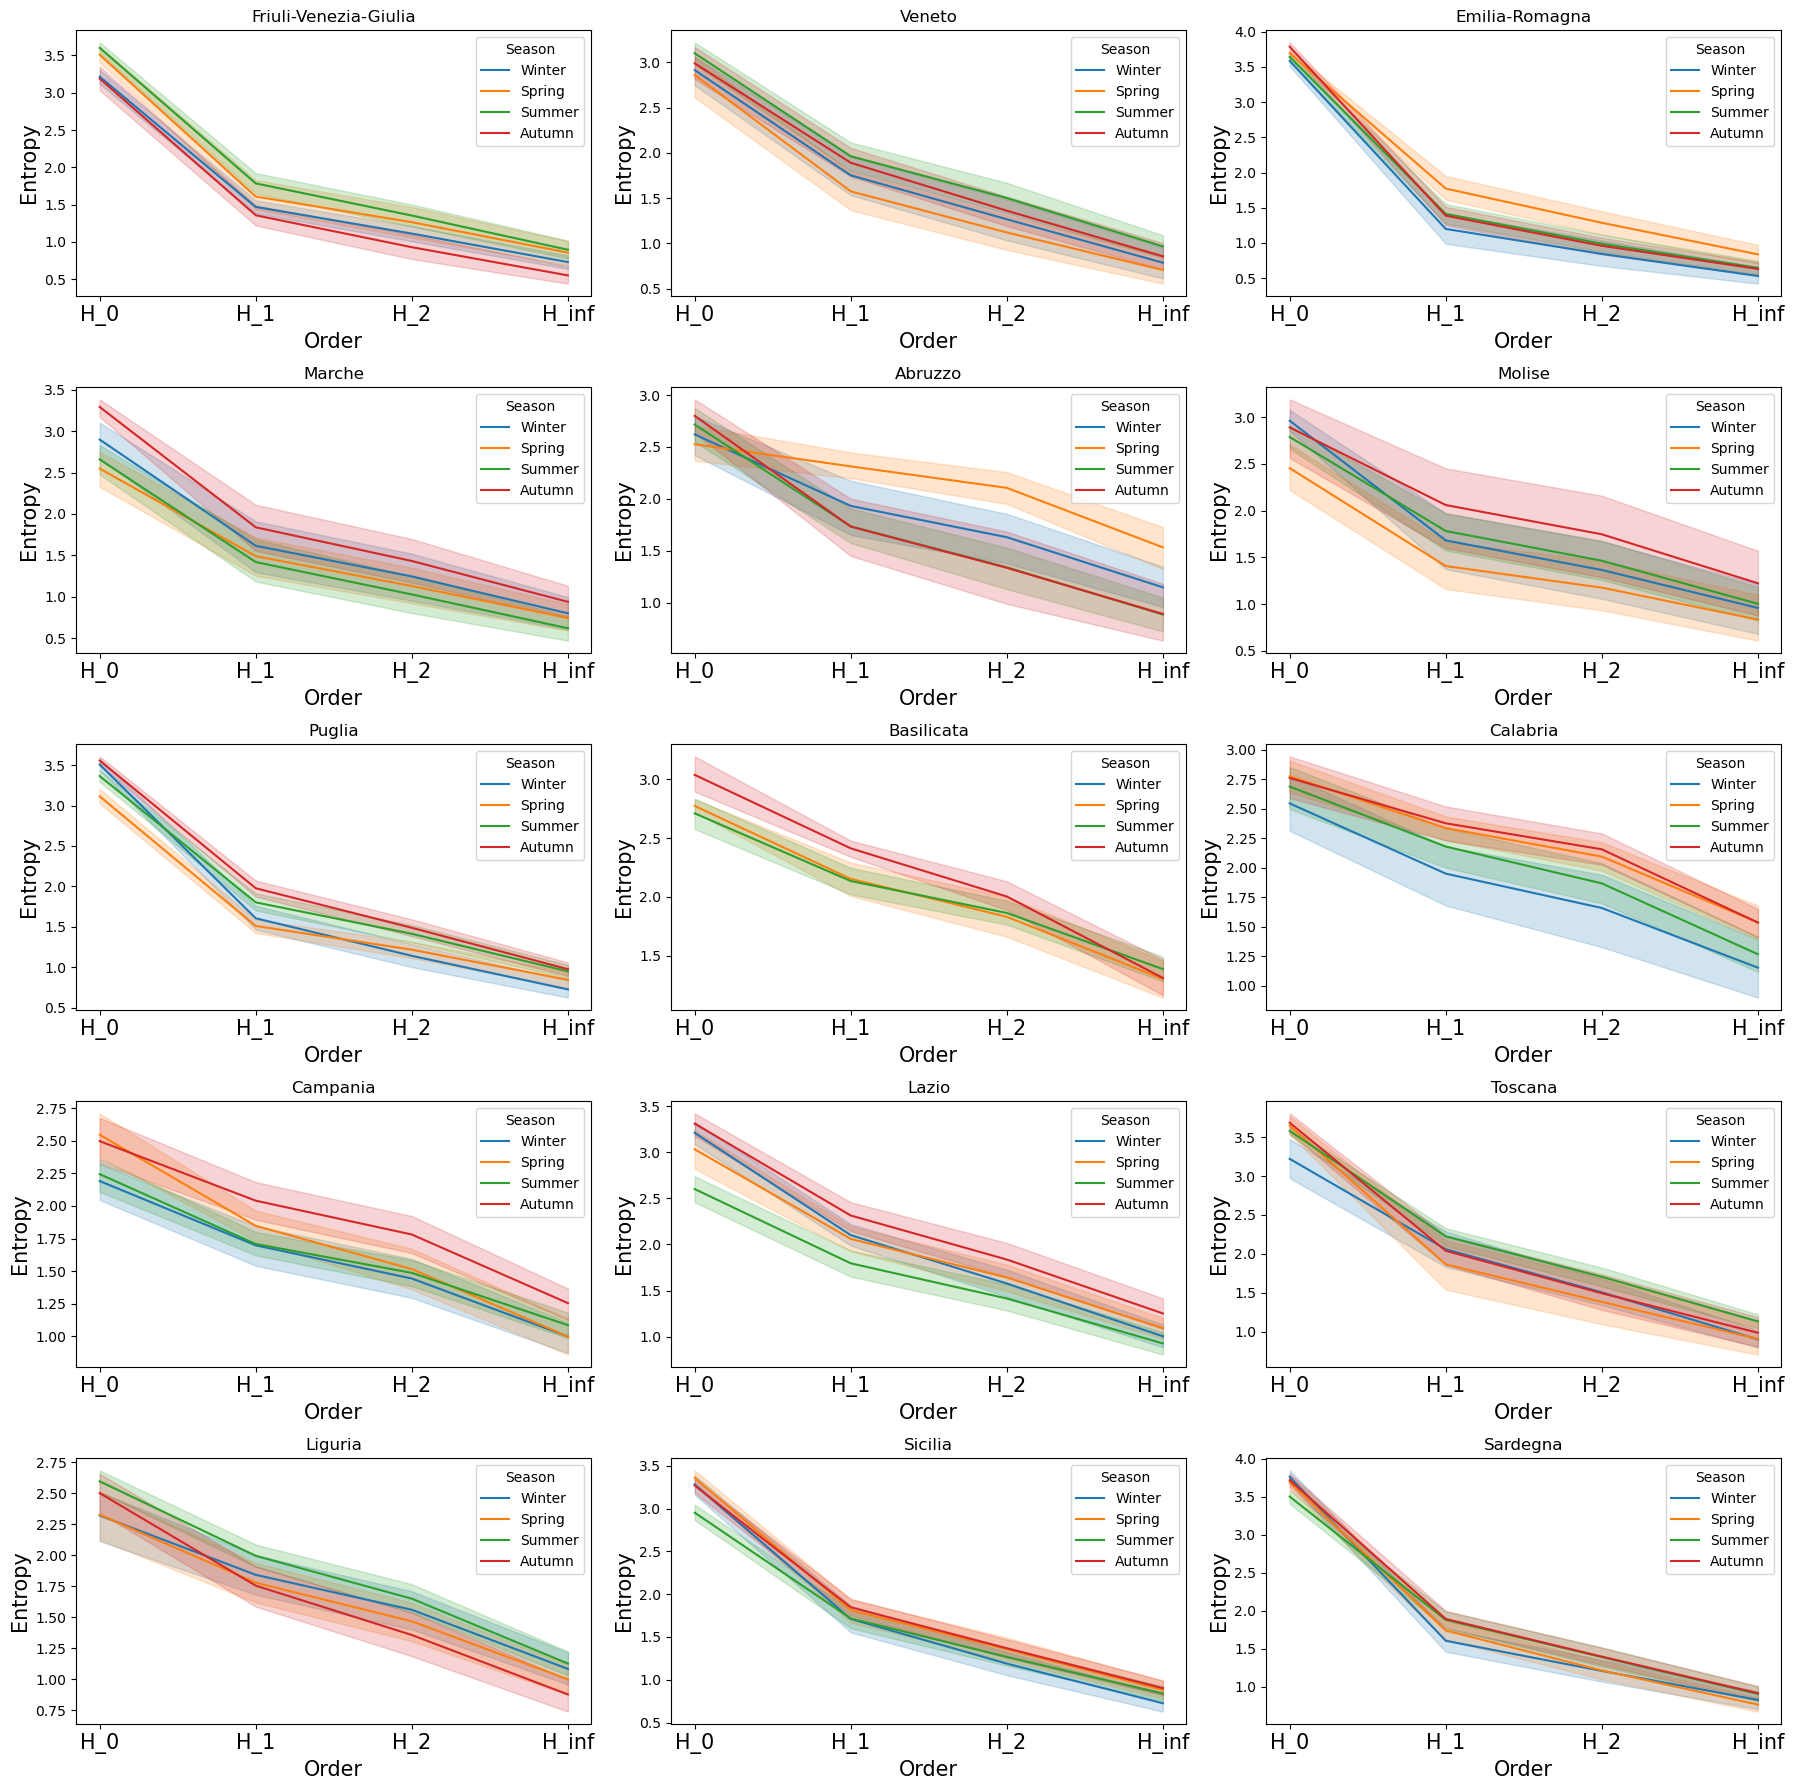

In [11]:
fig, axs = plt.subplots(5, 3, figsize=(18, 18))
axs = axs.flatten()

for ax, (region, df_region) in zip(axs, phyto_abund_simplified.query("Taxon != 'Other phytoplankton'")[["Region", "id", "Date", "Season", "Taxon", "Num_cell_l"]].groupby("Region", observed=True)):
    Renyi = df_region.groupby(["Region", "Season", "id", "Date"], observed=True).agg(
    H_0 = pd.NamedAgg(column = "Taxon",  aggfunc= lambda x: Renyi_entropy(x, 0)), 
    H_1 = pd.NamedAgg(column = "Num_cell_l",  aggfunc= lambda x: Renyi_entropy(x, 1)), 
    H_2 = pd.NamedAgg(column = "Num_cell_l",  aggfunc= lambda x: Renyi_entropy(x, 2)), 
    H_inf = pd.NamedAgg(column = "Num_cell_l",  aggfunc= lambda x: Renyi_entropy(x, "inf"))
    )
    Renyi.columns.name = "Order"
    Renyi = Renyi.stack()
    Renyi = Renyi.reset_index().rename(columns = {0 : "Entropy"})
    sns.lineplot(Renyi.reset_index(), x = "Order", y = "Entropy", hue = "Season", ax = ax)
    ax.set_title(region)
    ax.set_xlabel("Order", size = 15)
    ax.set_ylabel("Entropy", size = 15)
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), fontsize = 15);
plt.tight_layout()
#plt.savefig(_HOME_ + "/PHD/ISPRA_20152017_Analysis/Plots/Even_levels/boxplot_by_season_per_region.png")